# Populist radical right parties and International Cooperation in Party Manifestos

The aim of this notebook is to analyze how the strength of populist radical right parties affect the attitude of parties in government towards international cooperation. In particular, it analyzes party manifestos with respect to their sentiment towards international cooperation and the frequencies of words related to international cooperation.<br>
The core data and the texts of the party manifestos are retreived from the Manifesto Project API (https://manifesto-project.wzb.eu/information/documents/api). Data on the strength of populist radical right parties in the respective countries (vote share, seats share) come from the ParlGov database (http://www.parlgov.org/) and parties are defined as populist radical right according to the PopuList classifcation (https://popu-list.org).

#### Table of contents:
1. Importing the modules required
1. Collecting the data from the ParlGov database and the Manifesto Project API (core dataset)
2. Merging and processing the data
3. Visualization: diagrams on trends and populist radical right vs. other/government parties
4. Estimation of the effect of the strength of populist radical right parties on the attitude of government parties towards international cooperation
5. Fetching the party manifestos and text translation (Manifesto Project and Google Translate API)
6. Creating word clouds for word frequencies in party manifestos

## 1. Importing the modules required

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns
import os
import requests
import json
import sqlite3
import re
import nltk
nltk.download('brown')
from collections import defaultdict
from textblob import TextBlob
from wordcloud import WordCloud
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,Independence,Autoregressive)
from statsmodels.genmod.families import Poisson, Binomial

# Defines working directory
os.chdir(r"C:\Users\Oehler\Dropbox (GDI)\Populism and Aid\Python")

from google.cloud import translate_v2 as translate
""" 
Provides authentication credentials by setting the environment variable GOOGLE_APPLICATION_CREDENTIALS.
The JSON file contains the service account key (An account on Google Cloud platform (GCP) is needed
to use their official translation API (see https://cloud.google.com/translate/docs for instructions). 
"""
os.environ["GOOGLE_APPLICATION_CREDENTIALS"
          ]=r"Manifestos translation-1990eb511371.json"

## 2. Collecting the data from the ParlGov database and the Manifesto Project API

Retrieving the core dataset from the Manifesto Project API (latest version: 2019b).

In [34]:
# Retrieves the manifestos core dataset using the manifestos project's API
api_key_manifesto_project = os.getenv('api_key_manifesto_project')
version = {"key":"MPDS2019b"}
response = requests.get(
    "https://manifesto-project.wzb.eu/tools/api_get_core.json?api_key={}".format(api_key_manifesto_project),
    params=version)
manifestos_core_list = response.json()
manifestos_core = pd.DataFrame(manifestos_core_list[1:], columns=manifestos_core_list[0])

# Changes the data types to numerical and date and retrieves the year of the election
manifestos_core = manifestos_core.astype({'party': 'int64', 'pervote': 'float', 'absseat': 'float', 'totseats':
                                          'float', 'per107': 'float', 'per109': 'float', 'rile': 'float'})
manifestos_core['pervote']=np.round(manifestos_core['pervote'].values,1)
manifestos_core['edate'] = pd.to_datetime(manifestos_core['edate'],format="%d/%m/%Y")
manifestos_core['year'] = pd.DatetimeIndex(manifestos_core['edate']).year

# Restricts the manifestos dataset to the years from 1980 onwards
manifestos_core = manifestos_core[manifestos_core['year']>=1980]

Retrieving the ParlGov database from the ParlGov webpage to query the data from different tables with sqlite and importing them into a Pandas dataframe.

In [3]:
# Downloads the database and stores it in the working directory
request = requests.get("http://www.parlgov.org/static/data/parlgov-development.db")
with open('parlgov-development.db', 'wb') as f:
    f.write(request.content)
conn = sqlite3.connect('parlgov-development.db')

In [4]:
# Prints the columns of the three tables view_party, view_election and view_cabinet
view_party_columns = pd.read_sql_query("PRAGMA table_info(view_party)", conn)
print("Party\n",view_party_columns)
view_election_columns = pd.read_sql_query("PRAGMA table_info(view_election)", conn)
print("\nElection\n",view_election_columns)
view_cabinet_columns = pd.read_sql_query("PRAGMA table_info(view_cabinet)", conn)
print("\nCabinet\n", view_cabinet_columns)

Party
     cid                name         type  notnull dflt_value  pk
0     0  country_name_short                     0       None   0
1     1        country_name                     0       None   0
2     2    party_name_short                     0       None   0
3     3  party_name_english                     0       None   0
4     4          party_name                     0       None   0
5     5    party_name_ascii                     0       None   0
6     6   family_name_short  varchar(10)        0       None   0
7     7         family_name  varchar(50)        0       None   0
8     8          left_right         REAL        0       None   0
9     9        state_market         REAL        0       None   0
10   10   liberty_authority         REAL        0       None   0
11   11         eu_anti_pro         REAL        0       None   0
12   12                 cmp                     0       None   0
13   13          euprofiler                     0       None   0
14   14           

In [10]:
# Queries the database to get the data needed from the three tables
parlgov_data = pd.read_sql_query("""SELECT p.party_id,
                                    p.cmp,
                                    p.party_name_english,
                                    p.party_name_short,
                                    p.country_name_short,
                                    p.country_name,
                                    e.election_id,
                                    e.election_date,
                                    e.vote_share,
                                    /* Defines a variable for a party'a seats share in parliament */
                                    CAST(e.seats AS FLOAT)/CAST(seats_total AS FLOAT) seats_share,
                                    /* Defines a variable equal to one if a party was part of the last cabinet of an
                                    electoral term */
                                    LAST_VALUE(c.cabinet_party) OVER (PARTITION BY p.party_id, e.election_id
                                    ORDER BY c.start_date) AS cabinet_party
                                        FROM view_party p
                                        LEFT JOIN view_election e ON p.party_id=e.party_id
                                        LEFT JOIN view_cabinet c ON c.party_id=e.party_id AND
                                                                    c.election_id=e.election_id
                                        /* Uses only elections in national parliaments, not elections of the European
                                        parliament */
                                        WHERE e.election_type = "parliament"
                                        GROUP BY p.party_id, e.election_id
                                """, conn)

# Fills the missings in cabinet party with zeros
parlgov_data['cabinet_party'] = parlgov_data['cabinet_party'].fillna(0)

# Defines the date as datetime type and retrieves the year
parlgov_data['election_date'] = pd.to_datetime(parlgov_data['election_date'],format="%Y/%m/%d")
parlgov_data['date'] = pd.DatetimeIndex(parlgov_data['election_date'])
parlgov_data['year'] = pd.DatetimeIndex(parlgov_data['election_date']).year

## 3. Merging and processing the data

Some election date differ slightly between the data in the Manifestos Project and Parlgov. In order not to lose these data, I alternatively use the dates in Parlgov +/- one month. The two datasets are then merged on year and month of the elections in the next cell.

In [11]:
# Creates the altered dates
parlgov_data['date-1month'] = parlgov_data['date'] - pd.DateOffset(months=1)
parlgov_data['date+1month'] = parlgov_data['date'] + pd.DateOffset(months=1)

# Saves year and month from the date to a string in the format yyyymm (as in the manifestos project data)
variables = ['date','date-1month','date+1month']
for var in variables:
    for i, date in enumerate(parlgov_data[var]):
        parlgov_data.loc[i, var] = date.strftime("%Y%m")

# Creates two dataframes with the variables to merge with the alternative dates (year and month)
df_list = []
for string in ['date-1month','date+1month']:
    df = parlgov_data.drop('date', axis=1).rename(columns={string: 'date'})\
    .drop_duplicates(['party_id','date']).set_index(['party_id','date'])
    df_list.append(df)
parlgov_data_minus1, parlgov_data_plus1 = df_list
parlgov_data_minus1 = parlgov_data_minus1[['vote_share','seats_share','cabinet_party']]
parlgov_data_plus1 = parlgov_data_plus1[['vote_share','seats_share','cabinet_party']]

Merging the different datasets. Appart from the ParlGov and Manifesto Project data, I use the popuList dataset on European parties to define parties as populist radical right parties.

In [15]:
# Merges iso3-countrycodes to the countries
manifestos_countrycodes = {'Albania': 'ALB', 'Armenia': 'ARM', 'Australia': 'AUS', 'Austria': 'AUT', 'Azerbaijan': 'AZE',
                           'Belarus': 'BLR', 'Belgium': 'BEL', 'Bosnia-Herzegovina': 'BIH', 'Bulgaria': 'BGR',
                           'Canada': 'CAN', 'Croatia': 'HRV', 'Cyprus': 'CYP', 'Czech Republic': 'CZE',
                           'Denmark': 'DNK', 'Estonia': 'EST', 'Finland': 'FIN', 'France': 'FRA', 'Georgia': 'GEO',
                           'Germany': 'DEU', 'Greece': 'GRC', 'Hungary': 'HUN', 'Iceland': 'ISL', 'Ireland': 'IRL',
                           'Israel': 'ISR', 'Italy': 'ITA', 'Japan': 'JPN', 'Latvia': 'LVA', 'Lithuania': 'LTU',
                           'Luxembourg': 'LUX', 'Malta': 'MLT', 'Mexico': 'MEX', 'Moldova': 'MDA', 'Montenegro': 'MNE',
                           'Netherlands': 'NLD', 'New Zealand': 'NZL', 'Norway': 'NOR', 'Poland': 'POL',
                           'Portugal': 'PRT', 'Romania': 'ROU', 'Russia': 'RUS', 'Serbia': 'SRB', 'Slovakia': 'SVK',
                           'Slovenia': 'SVN', 'South Africa': 'ZAF', 'South Korea': 'KOR', 'Spain': 'ESP',
                           'Sri Lanka': 'LKA', 'Sweden': 'SWE', 'Switzerland': 'CHE', 'Turkey': 'TUR', 'Ukraine': 'UKR',
                           'United Kingdom': 'GBR', 'United States': 'USA'}
manifestos_countrycodes = pd.DataFrame(manifestos_countrycodes.items(), columns=['countryname','countrycode'])
manifestos_core_ccodes = pd.merge(manifestos_core, manifestos_countrycodes, on="countryname",
                                  how="left", validate="many_to_one")
manifestos_core_ccodes.loc[manifestos_core_ccodes['countryname']=="Northern Ireland",'countrycode']="GBR"

# Uses a linktables where party names of the manifestos and parlgov data have been matched manually
# in case they didn't correspond in order to merge the two datasets
manifestos_parlgov_link = pd.read_csv("manifestos_parlgov_linktable.csv", delimiter=";")
manifestos_parlgov_link = manifestos_parlgov_link.astype({'date':'str'})
manifestos_core_ccodes_link = pd.merge(manifestos_core_ccodes, manifestos_parlgov_link, left_on=["party","date"],
                                       right_on=["cmp","date"], how="left", indicator=True, validate="one_to_one")
manifestos_core_ccodes_link = manifestos_core_ccodes_link.rename(columns = {'_merge':'link'})
parlgov_data = parlgov_data.drop_duplicates(["party_id","election_date"])
manifestos_parlgov = pd.merge(manifestos_core_ccodes_link, parlgov_data, on=["party_id","date"],
                              how="left", indicator=True, validate="many_to_one")
manifestos_parlgov = manifestos_parlgov.rename(columns = {'_merge':'_merge_manifestos_parlgov'})

# Merges the parlgov data to the manifestos data with alternativ dates (see above on slightly differing dates)
# and updates the respective variables
manifestos_parlgov = pd.merge(manifestos_parlgov, parlgov_data_minus1, on=["party_id","date"], 
                              how="left", validate="many_to_one")
manifestos_parlgov = pd.merge(manifestos_parlgov, parlgov_data_plus1, on=["party_id","date"],
                              how="left", validate="many_to_one")
for var1 in ['vote_share','seats_share','cabinet_party']:
    for var2 in ['','_y']:
        manifestos_parlgov.loc[manifestos_parlgov[var1+'_x'].isnull(),var1+'_x']=manifestos_parlgov[var1+var2]

#Sets the binary variable prrp to 0 if the party is not a right-wing populist party in the sampe
#of the European countries in the popuList dataset
popuList_parties = ["42710", "42420", "21917", "80710", "80062", "80620", "80640", "81952", "82710", "82721", "82720",
                    "13720", "13951", "83720", "14820", "31720", "41953", "34710", "34512", "86421", "86710", "86620",
                    "32630", "32720", "22711", "22730", "22722", "12951", "92713", "92712", "92436", "93712", "93711",
                    "96710", "96725", "97330", "97710", "11951", "11710", "43951","43901", "43902", "43810", "51951"]
popuList_countries = ["AUT","BEL","BGR","HRV","CZE","DNK","EST","FIN","FRA","DEU","GRC","HUN","ITA","LTU","NLD","NOR",
                      "POL","PRT","ROU","SVK","SVN","ESP","SWE","CHE","GBR"]
manifestos_parlgov.loc[manifestos_parlgov['countrycode'].isin(popuList_countries) &
                            manifestos_parlgov['party'].isin(popuList_parties)==1,'prrp']=1
manifestos_parlgov.loc[manifestos_parlgov['countrycode'].isin(popuList_countries) &
                            manifestos_parlgov['party'].isin(popuList_parties)==0,'prrp']=0
manifestos_parlgov_popu = manifestos_parlgov

Visualizing missings in the cabinet party variable retrieved from the parlgov data to check for data gaps.

In [ ]:
sns.set(style="ticks", font_scale=3)
plt.figure(figsize=(35,12))
plt.xticks(rotation=90)
sns.countplot(data=manifestos_parlgov.countryname, x=manifestos_parlgov.cabinet_party_x.isnull());

I checked the missings in the respective countries: Most missing are from countries not present in the ParlGov data (most European countries in the database). The other missings are very small parties with party manifestos but not present in the ParlGov data.<br><br> 

Creating the target variables (share of positive and negative statements with respect to internationa cooperation in the party manifestos and the sum of the two) and the explanatory variables (features) we are most interested in (vote and seats share of right-wing populist parties)

In [29]:
# Creates the target variables
manifestos_parlgov_popu = manifestos_parlgov_popu.rename({'per107' : 'inter_pos', 'per109' : 'inter_neg'}, axis=1)
manifestos_parlgov_popu['inter'] = manifestos_parlgov_popu['inter_pos']+manifestos_parlgov_popu['inter_neg']

# Changes the variables from percentages to shares
for var in ['pervote','inter_neg','inter_pos','inter']:
    manifestos_parlgov_popu[var+'_share'] = manifestos_parlgov_popu[var] / 100
    
# Calculates the share of seats in the parliament for the respective party
manifestos_parlgov_popu['perseats_share'] = manifestos_parlgov_popu['absseat'] / manifestos_parlgov_popu['totseats']

# Calculates the aggregate vote and seats share by right-wing populist parties in a country and election year
# and merges the variables to the original dataset
manifestos_parlgov_popu['year'] = pd.DatetimeIndex(manifestos_parlgov_popu['edate']).year
vote_seats_share_prrp = manifestos_parlgov_popu[manifestos_parlgov_popu['prrp']==1].groupby(['country','date'])\
[['pervote_share','perseats_share']].sum().reset_index()
vote_seats_share_prrp = vote_seats_share_prrp.rename(
    columns={'pervote_share': 'vote_share_prrp', 'perseats_share': 'seats_share_prrp'})
manifestos_parlgov_popu = manifestos_parlgov_popu.merge(vote_seats_share_prrp, on=['country','date'], how='left')

## 4. Visualization: diagrams on trends and right-wing vs. other/government parties

In [36]:
# Defines a fuction to label the axes
def set_labels(ax):
    """Sets the x and y label for a diagram"""
    ax.set_ylabel('Sentences share: international cooperation')
    ax.set_xlabel('Year')

Creating a diagram showing positive and negative statements with respect to international cooperation in party manifestos (1980 - 2018; all countries in the Manifesto Project data).

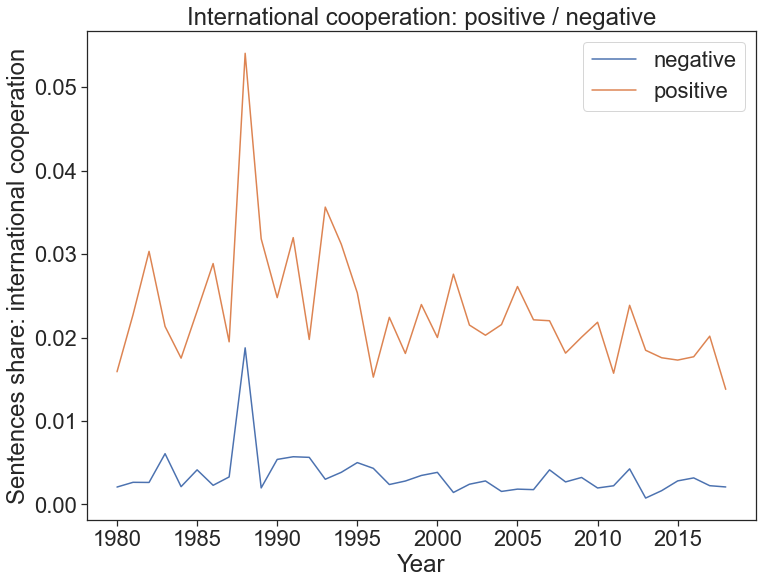

In [37]:
sns.set(style="ticks", font_scale=2)
ax = pd.pivot_table(manifestos_parlgov_popu, index='year', values=['inter_pos_share','inter_neg_share']).plot(
    title="International cooperation: positive / negative", figsize=(12,9))
ax.legend(['negative','positive'])
set_labels(ax)

The diagram shows that over the whole period positive statements with respect international cooperation prevail negative ones. Remarkably, we can observe a peak in sentences related to internatinal cooperation in the late 80ies before the fall of the Iron Curtain. Importantly, we observe a negative trend in the positive statements in the 21rst century.<br><br>

Creating a diagram showing the evolution of the attitude towards international cooperation in party manifestos for some seleced countries (France, Germany, United Kingdom, United States).

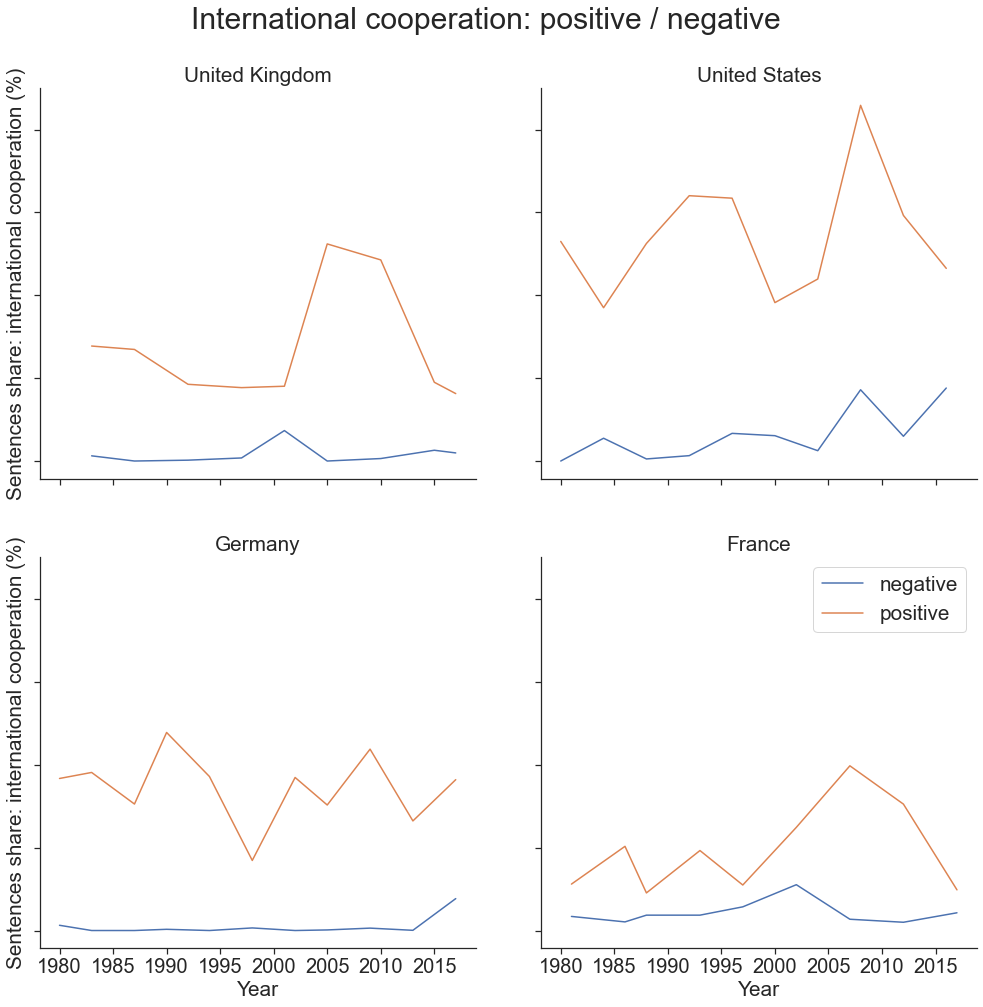

In [38]:
# Some data wrangling to get the data in the needed shape for the last diagram
inter_year_agg = manifestos_parlgov_popu[['year','countryname','inter_pos_share','inter_neg_share','vote_share_prrp',
                                         'seats_share_prrp']].groupby(['year','countryname']).mean().reset_index()
inter_year_agg_countries = inter_year_agg[inter_year_agg['countryname'].
                                          isin(['France','Germany','United Kingdom','United States'])]

inter_year_agg_c_long = pd.melt(inter_year_agg_countries, id_vars=['year','countryname'],
                                value_vars=['inter_pos_share','inter_neg_share'], var_name="pos_neg", value_name="inter")
inter_year_agg_c_long['pos_neg'] = inter_year_agg_c_long['pos_neg'].str.replace("inter_","")
inter_year_agg_c_long = inter_year_agg_c_long.sort_values('pos_neg')

# Creates the diagram
sns.set(style="ticks", font_scale=1)
g = sns.FacetGrid(inter_year_agg_c_long, col='countryname', hue='pos_neg', height=7, col_wrap=2)
g.map(sns.lineplot, 'year', 'inter')
g.set_ylabels('Sentences share: international cooperation (%)', size='xx-large')
g.set_xlabels('Year', size='xx-large')
g.set_titles('{col_name}', size='xx-large')
plt.subplots_adjust(top=0.90, hspace=0.2, wspace=0.15)
g.fig.suptitle('International cooperation: positive / negative', fontsize=30)
plt.legend(['negative','positive'],fontsize='xx-large')
g.set_yticklabels(size = 20)
g.set_xticklabels(size = 20)
for ax in g.axes.flat:
    _ = plt.setp(ax.get_yticklabels(), visible=True)
    _ = plt.setp(ax.get_xticklabels(), visible=True) 
plt.show()

In France, the UK and the United States we see a decline in the postive statements on international cooperation over the last 10 years (after a peak at around 2005). In particular in the US, we can observe at the same time an increase in negative statements on international cooperation.<br>
This trend cannot be observed in Germany, although there has also been a certain increase in negative statements over the last years (with the formation of the AFD).<br><br>

Creating a number of diagrams to show the evolution of the attitude towards international cooperation over time
(1980 - 2018) and between populist radical right parties (PRRPs) and other/government parties in European countries.

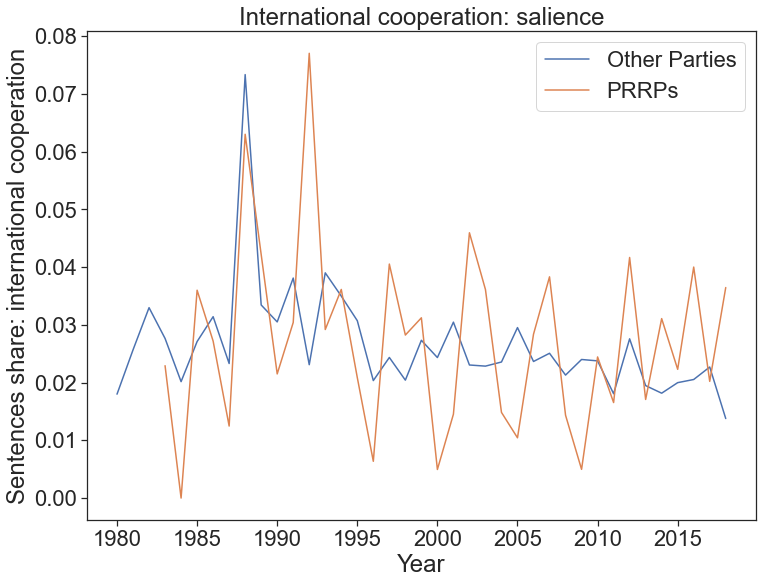

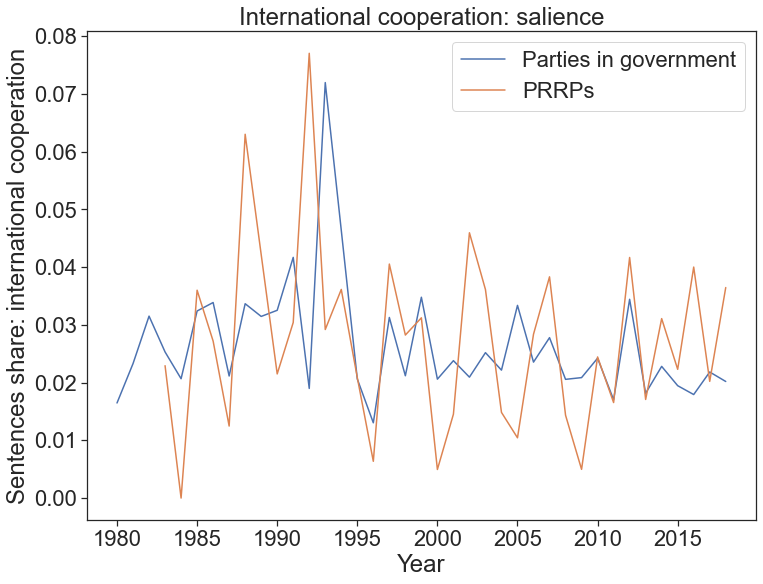

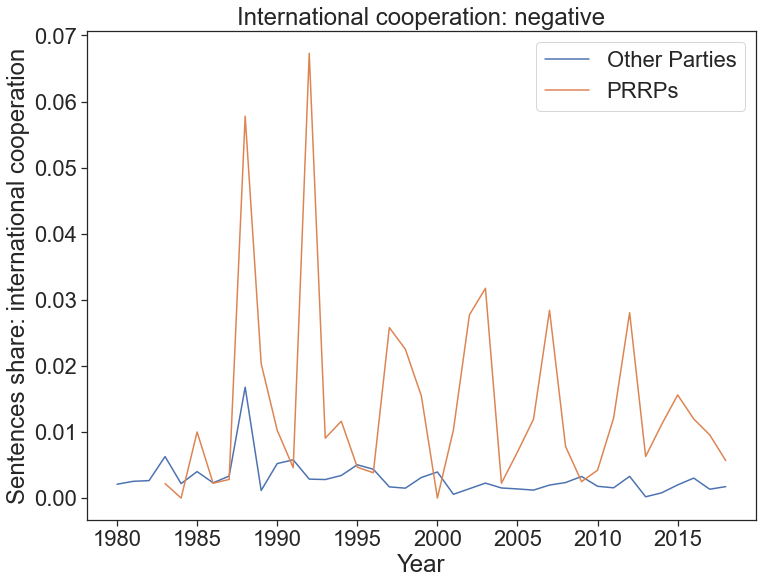

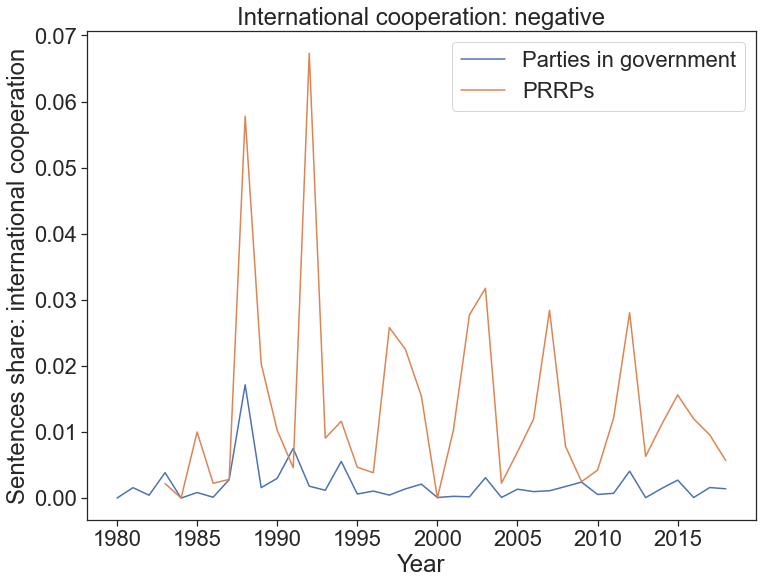

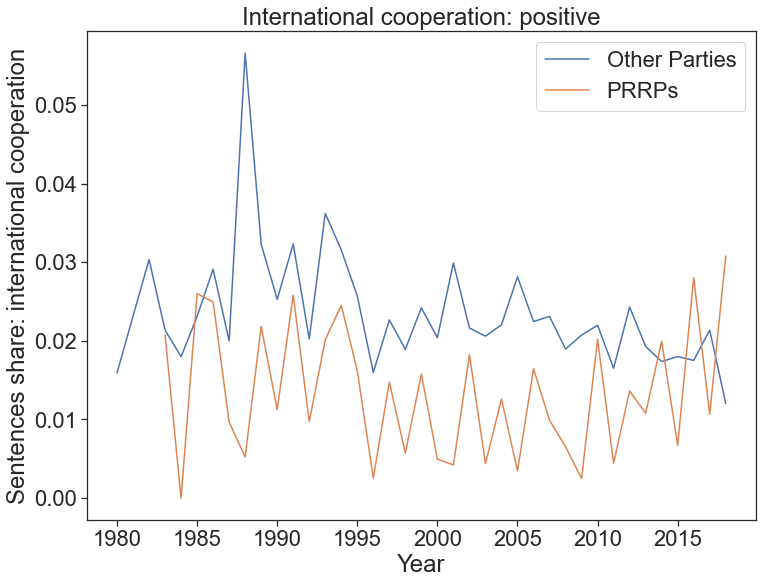

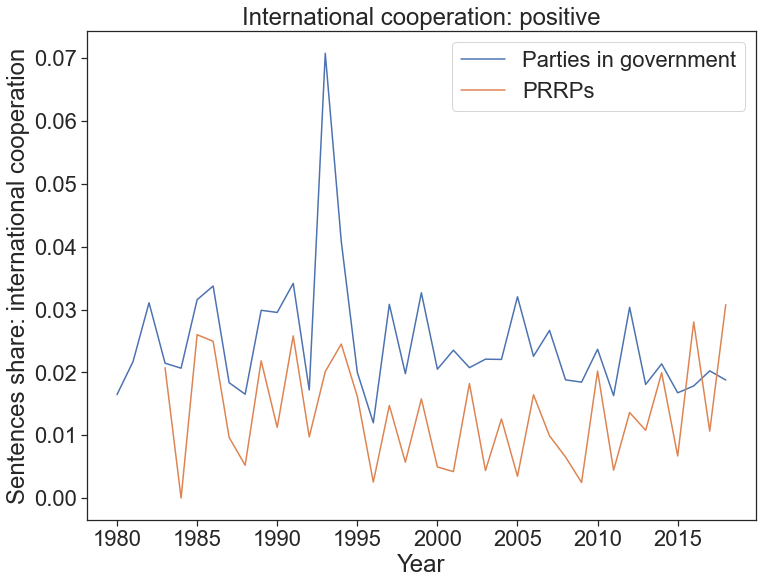

In [39]:
# Creates a binary variable equals 0 if the party is in government but not a right-wing populist party,
# and 1 if the party is a right-wing populist party
manifestos_parlgov_popu.loc[(manifestos_parlgov_popu['cabinet_party_x']==1) & (
    manifestos_parlgov_popu['prrp']==0),'prrp_vs_gov_party']=0
manifestos_parlgov_popu.loc[manifestos_parlgov_popu['prrp']==1,'prrp_vs_gov_party']=1

# Creates the diagrams
sns.set(style="ticks", font_scale=2)
for k1, v1 in {'inter_share': 'International cooperation: salience','inter_neg_share': 
             'International cooperation: negative','inter_pos_share': 'International cooperation: positive'}.items():
    for k2, v2 in {'prrp': 'Other Parties','prrp_vs_gov_party': 'Parties in government'}.items():  
        ax = pd.pivot_table(manifestos_parlgov_popu, index='year', columns=k2, values=k1).plot(
            title=v1, figsize=(12,9))
        ax.legend([v2,'PRRPs'])
        set_labels(ax)

The diagrams compare the salience and attitude towards international cooperation in party manifestos between populist radical right parties and all other parties or the parties in government (but not populist radical right).<br>
The first two diagrams show that there is no significant difference between populist radical right parties and other parties with respect to the salience of international cooperation in party manifestos.
On the other hand, negative statements with respect to international cooperation are significantly more common in the case of populist radical right parties compared to other/government parties (3rd and 4th diagram).
In the case of positive statements on international cooperation, we can observe the opposite: Other/government parties more often formulate positive statements on internation cooperation in their party manifestos compared to populist radical right parties.<br><br>

Creating a figure showing the vote share of populist radical right parties and the share of positive statements with respect to international cooperation over time (as an average over all Western European countries).

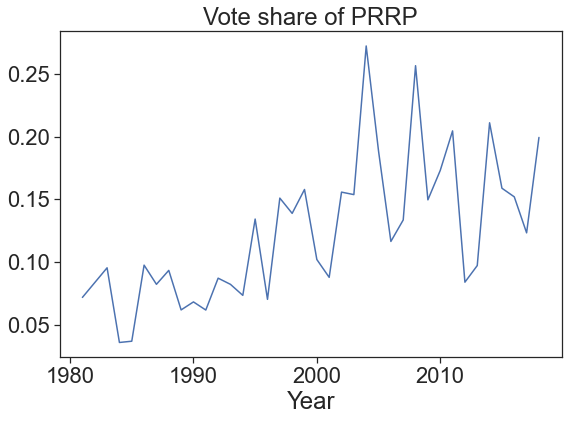

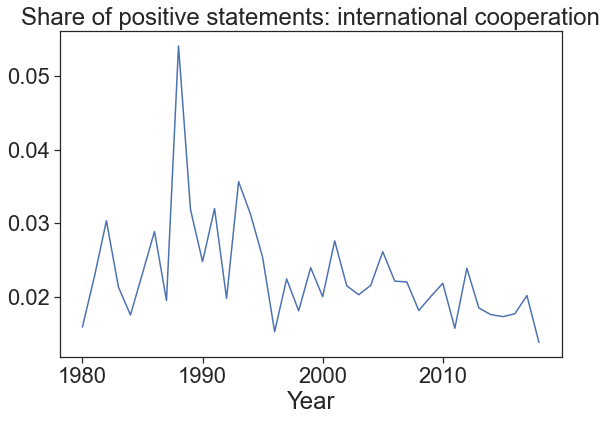

In [227]:
manifestos_parlgov_popu_western_europe = manifestos_parlgov_popu[manifestos_parlgov_popu['countrycode'].isin([
    "BGR","CZE","EST","HRV","HUN","LTU","POL","ROU","SVK","SVN"])==False]

ax = pd.pivot_table(manifestos_parlgov_popu, index='year', values=['vote_share_prrp']).plot(
    title='Vote share of PRRP', figsize=(9,6))
ax.set_xlabel('Year')
ax.get_legend().remove()

ax = pd.pivot_table(manifestos_parlgov_popu, index='year', values=['inter_pos_share']).plot(
    title='Share of positive statements: international cooperation', figsize=(9,6))
ax.set_xlabel('Year')
ax.get_legend().remove();

While we can observe a trend towards a higher averageg vote share of populist radical right parties in Western European countries, there is some indication that the average share of positive statements with respect to international cooperation decreased over time.

## 5. Estimation of the effect of the strength of populist radical right parties on the attitude of government parties towards international cooperation

Creating some features for the estimation.

In [40]:
# Only uses the countries in the PopuList dataset
manifestos_parlgov_popu_c = manifestos_parlgov_popu[manifestos_parlgov_popu['countrycode'].isin(popuList_countries)]

# Creates a dummy variable on whether a party has been in the government in the previous term
manifestos_parlgov_popu_c = manifestos_parlgov_popu_c.set_index(['party','date'])
cabinet_party = manifestos_parlgov_popu_c[['cabinet_party_x']].groupby(level=0).shift(1).reset_index()
cabinet_party.loc[cabinet_party['cabinet_party_x'].isnull(),'cabinet_party_x'] = 0
cabinet_party = cabinet_party.rename(columns={'cabinet_party_x': 'l_cabinet_party'})
manifestos_parlgov_popu_c_lcab = manifestos_parlgov_popu_c.merge(cabinet_party, on=['party','date'], how='left')

# Creates a dummy variable on whether a party is right-wing populist and has been in the government in the previous term
manifestos_parlgov_popu_c_lcab['prrp_ingov'] = (manifestos_parlgov_popu_c_lcab['prrp']==1) & (
    manifestos_parlgov_popu_c_lcab['cabinet_party_x']==1)

""" Creates variables for the vote and seat share of right-wing populist parties in the previous election and whether
there has been a right-wing populist party in government in the previous term. In addition we calculate the median
of the vote and seats share in each country (in order to divide the sample later on) """
vote_seats_share_prrp = manifestos_parlgov_popu_c_lcab.groupby(['country','date'])[[
    'vote_share_prrp','seats_share_prrp','prrp_ingov']].max()
vote_seats_share_prrp_median= vote_seats_share_prrp.groupby('country')[['vote_share_prrp','seats_share_prrp'
                                                                      ]].median().reset_index()
for var in ['vote_share_prrp','seats_share_prrp']:
    vote_seats_share_prrp_median.loc[vote_seats_share_prrp_median[var].isnull(),var] = 0
vote_seats_share_prrp_median = vote_seats_share_prrp_median.rename(
    columns={'vote_share_prrp': 'l_vote_share_prrp_median', 'seats_share_prrp': 'l_seats_share_prrp_median'})
for var in ['vote_share_prrp','seats_share_prrp','prrp_ingov']:
    vote_seats_share_prrp.loc[vote_seats_share_prrp[var].isnull(),var] = 0
vote_seats_share_prrp = vote_seats_share_prrp.groupby(level=0).shift(1).reset_index()
vote_seats_share_prrp = vote_seats_share_prrp.rename(columns={'vote_share_prrp' : 'l_vote_share_prrp', 'seats_share_prrp':
                                                              'l_seats_share_prrp', 'prrp_ingov': 'l_prrp_ingov'})
manifestos_parlgov_popu_lag = manifestos_parlgov_popu_c_lcab.merge(vote_seats_share_prrp, on=[
    'country','date'], how='left')
manifestos_parlgov_popu_lag = manifestos_parlgov_popu_lag.merge(vote_seats_share_prrp_median, on=[
    'country'], how='left')

Defining our estimation sample by selecting the parties which have been in government for the previous term and which not are populist radical right parties.

In [41]:
manifestos_parlgov_popu_govparties = manifestos_parlgov_popu_lag[(manifestos_parlgov_popu_lag['l_cabinet_party']==1) &
    (manifestos_parlgov_popu_lag['prrp']!=1)]

Setting up the variables for the estimation and defining a sample comprising only Western European countries.

In [42]:
# We have three dependent variables: share of (positive/negative) statements on international cooperation in total
# statements in the party manifestos
y = manifestos_parlgov_popu_govparties[['inter_share','inter_pos_share','inter_neg_share']]

# Selects the features for the estimation.
x = manifestos_parlgov_popu_govparties[['countrycode','year','l_vote_share_prrp','l_seats_share_prrp',
                                                   'l_prrp_ingov','rile']]

# The year variables needs to be a string in order to use it as dummy variables in the regression.
x = x.astype({'year': 'str'})

# The complete data to use for the estimation
data = pd.concat([y,x], axis=1)

# Selects only Western European countries
data_western_europe = data[data['countrycode'].isin(["BGR","CZE","EST","HRV","HUN","LTU","POL","ROU","SVK","SVN"])
                           ==False]


Estimating a fractional model because of the dependent variable is a share (share of positive statements on
international cooperation in total statements in the party manifestos).

In [57]:
# We also include country dummy variables to account for heterogeity across countries and year dummy variables for
#common time trends. In addition, we cluster the standard errors by country.
model = GEE.from_formula("inter_pos_share ~ l_prrp_ingov + l_vote_share_prrp + rile + countrycode + year",
                         "countrycode", data_western_europe, cov_struct=Independence(), family=Binomial())
result = model.fit()
print(result.summary())

                               GEE Regression Results                              
Dep. Variable:             inter_pos_share   No. Observations:                  299
Model:                                 GEE   No. clusters:                       15
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                  35
Family:                           Binomial   Mean cluster size:                19.9
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 09 Oct 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         12:53:16
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.2006      0.209    -10.542      0.000  

The estimation results show a statistically significant (at the 1% percent level) and negative effect of the strength of populist radical right parties (measured by their vote share in the previous election) on the share of positive statements in total statements in government party manifestos.<br><br>
We now estimate the marginal effects to interpret the effect quantitatively.

In [78]:
print(result.get_margeff().summary())

         GEE Marginal Effects        
Dep. Variable:        inter_pos_share
Method:                          dydx
At:                           overall
                          dy/dx    std err          z      P>|z| [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
l_prrp_ingov[T.True]     0.0017      0.008      0.206      0.837             -0.014
countrycode[T.BEL]      -0.0233      0.005     -4.995      0.000             -0.032
countrycode[T.CHE]       0.0015      0.008      0.190      0.849             -0.014
countrycode[T.DEU]      -0.0186      0.006     -3.060      0.002             -0.031
countrycode[T.DNK]      -0.0243      0.004     -6.430      0.000             -0.032
countrycode[T.ESP]      -0.0221      0.006     -3.762      0.000             -0.034
countrycode[T.FIN]      -0.0225      0.005     -4.625      0.000             -0.032
countrycode[T.FRA]      -0.0238      0.004     -5.665      0.000             -0.032
countryc

An increase in the vote share of populist radical right parties by 10 percentage points leads to a decrease in the share of positive statements in total statements of almost 1 percentage point.

## 6. Fetching the party manifestos and text translation (Manifesto Project and google translate API)

In [ ]:
# Defines a variable combining the party id and the election date
manifestos_parlgov_popu_govparties['party_date']=manifestos_parlgov_popu_govparties.loc[:,'party'
        ].astype(str)+"_"+manifestos_parlgov_popu_govparties.loc[:,'date'].astype(str)

This code fetches the party manifestos in Western European countries in the period 1980-2018 (with the help of the Manifesto Project API). In the case of the text being in another language than english, it translates the sentences to english (with the Google Translate API). Finally, it saves the sentences of each party manifesto in a Pandas dataframe with a row consisting of one sentence.

In [ ]:
# Sets up the Google Translate Client with english as the target language
translate_client = translate.Client(target_language="en")

# Defines the sample of party manifestos (of Western European countries)
country_list = ["AUT","BEL","CHE","DEU","DNK","ESP","FRA","FIN","GBR","GRC","ITA","NLD","NOR","PRT","SWE"]
manifestos_core_selection = manifestos_parlgov_popu_govparties[manifestos_parlgov_popu_govparties['countrycode'
                                                                                                  ].isin(country_list)]
party_date = list(manifestos_core_selection['party_date'])
                                
manifestos_rows = []
for elem in party_date:
    # Fetches the respective party manifestos id from the metadata
    parameters_1 = {"keys[]" : elem, "version" : "2019-2"}
    retrieve_manifesto_id = requests.get("https://manifesto-project.wzb.eu/tools/api_metadata.json?"+
                                         "api_key=57a6b1f6090c40c4e2f70287e2c8db40", params=parameters_1)
    retrieve_manifesto_id_json = retrieve_manifesto_id.json()
    try:
        manifesto_id = retrieve_manifesto_id_json['items'][0]['manifesto_id']
        # Fetches the corpus data of the respective manifesto if it exists
        if manifesto_id != None:
            parameters_2 = {"keys[]" : manifesto_id, "version" : "2019-2"}
            response = requests.get("https://manifesto-project.wzb.eu/tools/api_texts_and_annotations.json?"+
                                    "api_key=57a6b1f6090c40c4e2f70287e2c8db40", params=parameters_2)
            # Saves the corpus data in a nested dictionary and selects the data needed
            content = response.json()
            if content['items']!=[]:
                content_list = content['items'][0]['items']
            # This condition checks whether the text has been annotated, i.e., divided ino quasi-sentences and assigned
            # a code for topic (for instance for international cooperation) to each quasi-sentence
            if len(content_list) > 1:                    
                sentences = []
                for i, item in enumerate(content_list):
                    # Defines a variable for the topic code and chooses those sentences with topic codes equal to 
                    # international cooperation (positive/negative statements)
                    cmp_code = item['cmp_code']
                    if cmp_code == '107' or cmp_code == '109':
                        # Defines a variable for the sentences in the original language
                        if 'text' in content_list[0].keys(): 
                            sentence_original = item['text']
                        else:
                            sentence_original = item['content']
                        # Defines a variable for party_id and date and a consecutive number
                        party_date = '{}'.format(elem)
                        sentence_num = '{}'.format(i+1)
                        # If the party manifesto in english, we don't have to translate the text
                        if re.match("51", elem): 
                            sentence = sentence_original
                        else:
                            # Translates the text to english
                            result = translate_client.translate(sentence_original, format_="text")
                            sentence = result['translatedText']
                            sentence = sentence.replace('\u200b', '')
                        # Appends the variables to a list
                        manifestos_rows.append((party_date, sentence_num, sentence, sentence_original, cmp_code))
    # Defines an exception in case the code raises an IndexError (in case no corpus data exists)
    # Continue assures that the loop jumps to the next elment (party_manifesto) in the list
    except IndexError:
        continue
    
manifestos_sentences = pd.DataFrame(manifestos_rows, columns=['party_date', 'sentence_num', 'sentence',
                                                              'sentence_original','cmp_code'])
manifestos_sentences = manifestos_sentences.astype({'cmp_code': 'int64'})

## 7. Creating word clouds for word frequencies in party manifestos

Using the TextBlob module to extract noun phrases from the sentences.

In [168]:
manifestos_sentences['tokens'] = manifestos_sentences['sentence'].apply(lambda w: TextBlob(str(w)).noun_phrases)

Dividing the data according to a variable indicating whether the vote share of right-wing populist parties in the previous election was below or above the median in the respective country.

In [169]:
manifestos_sentences_ext = pd.merge(manifestos_sentences, manifestos_parlgov_popu_govparties, on='party_date', how='left')
manifestos_sentences_ext['vote_share_prrp_above_median']=manifestos_sentences_ext[
    'l_vote_share_prrp']>manifestos_sentences_ext['l_vote_share_prrp_median']

Creating dictionaries for the different word counts: frequency of each word in positive/negative statements with respect to international cooperation in the samples above and below the median.

In [170]:
word_freq_pos_ab_m = defaultdict(int)
word_freq_pos_be_m = defaultdict(int)
word_freq_neg_ab_m = defaultdict(int)
word_freq_neg_be_m = defaultdict(int)

for i, row in manifestos_sentences_ext.iterrows():
    for token in row['tokens']:
        # for positive statements
        if row['cmp_code']==107:
            if row['vote_share_prrp_above_median'] == True:
                word_freq_pos_ab_m[token] += 1
            else:
                word_freq_pos_be_m[token] += 1
        # negative statements (cmp_code=109)
        else:
            if row['vote_share_prrp_above_median'] == True:
                word_freq_neg_ab_m[token] += 1
            else:
                word_freq_neg_be_m[token] += 1

Creating word clouds for the positive statements on international cooperation for the samples with the vote share of right-wing populist parties below and above the median.


Positive statements with respect to international cooperation below the median in the vote share of PRRPs


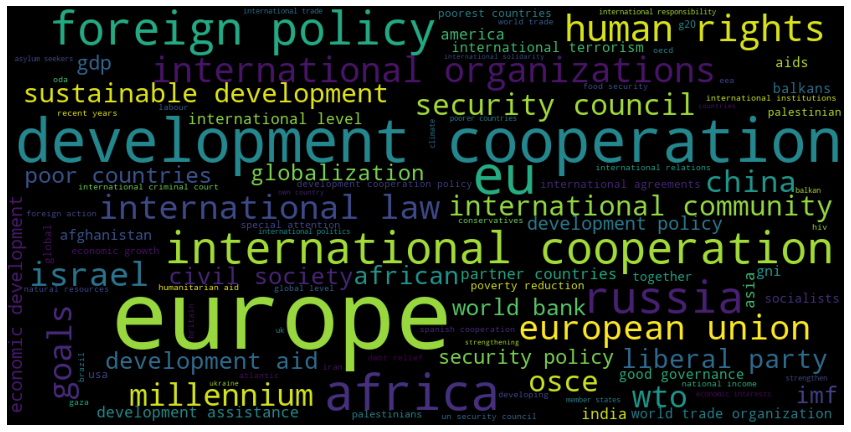


Positive statements with respect to international cooperation above the median in the vote share of PRRPs


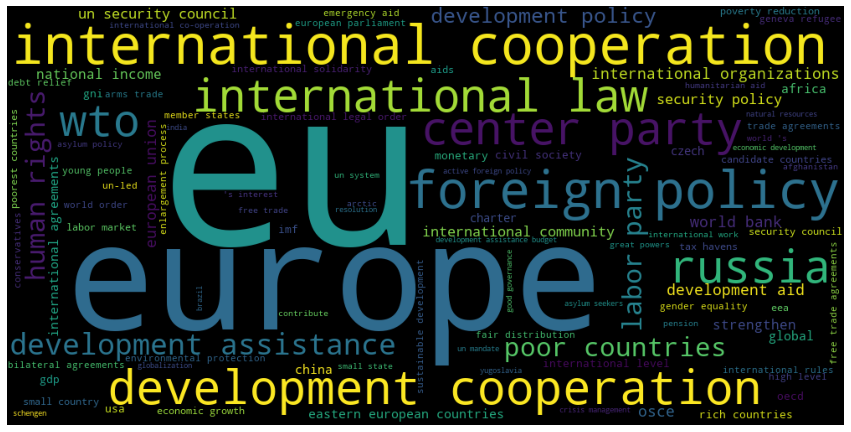

In [175]:
country_names = ['norway','norwegian','austria','switzerland','sv','nordic','austrian','netherlands','finland','belgium',
                'dutch','barents','spain','germany','austria','sweden','mediterranean','france','belgium','greece','vld',
                'vvd','denmark','d66','flanders','cda','cdv','psoe','krf','vienna','important part','continue',
                'spanish society']

for (d, t) in zip([word_freq_pos_be_m, word_freq_pos_ab_m],['below','above']):
    print("\nPositive statements with respect to international cooperation {}\
 the median in the vote share of PRRPs".format(t))
    for c in country_names:
        if c in d:
            d.pop(c)
    wordcloud = WordCloud(width = 1000, height = 500, max_words=100).generate_from_frequencies(d)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

The word clouds clearly show that in the sample of country-year pairs where the vote share of right-wing populist parties is above the median in the respective country there is a much stronger focus on the Europe and especially the EU in positive statements with respect to international cooperation. This can be interpreted as parties in government feeling a stronger need to emphasize the importance and advantages of the EU when right-wing populims is relatively strong.<br>
In the sample below the median on the other hand, we see more diverse picture with respect to key words. One example that stands out is Africa, which is quite often mentioned in the sample below the median but far less in the sample above the median. So it seems that strong right-wing populist parties drive parties in government away from a focus on Africa when it comes to international cooperation.